In [ ]:
from transformers import WhisperForConditionalGeneration
print("WhisperForConditionalGeneration is working!")

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.signal import resample
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader


from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
from transformers import WhisperForConditionalGeneration

In [ ]:
!pip install evaluate
!pip install jiwer

In [ ]:
import evaluate
from jiwer import cer

def down_sample_audio(audio_original, original_sample_rate):
    target_sample_rate = 16000

    # Calculate the number of samples for the target sample rate
    num_samples = int(len(audio_original) * target_sample_rate / original_sample_rate)

    # Resample the audio array to the target sample rate
    downsampled_audio = resample(audio_original, num_samples)

    return downsampled_audio

In [ ]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

In [ ]:
from transformers import WhisperTokenizer, WhisperFeatureExtractor, WhisperForConditionalGeneration
import torch

# Define device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load tokenizer and feature extractor
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language="spanish", task="transcribe")
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small", language="spanish", task="transcribe")

# Load model and move to appropriate device
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device)

In [ ]:
odia_text = "Upepeténtevoi omopu'ã tapỹi tupemi ha oiko ipype ha'eño peteĩ"

tokenized_text = tokenizer(odia_text)

tokenizer.decode(tokenized_text.input_ids)

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from datasets import load_dataset_builder

# Inspect dataset without downloading data
dataset_builder = load_dataset_builder(
    "mozilla-foundation/common_voice_17_0",
    "gn",
    trust_remote_code=True
)
print(dataset_builder.info.splits)
print(dataset_builder.info.features)

In [ ]:
from datasets import load_dataset,concatenate_datasets

#cv_19 = load_dataset("fsicoli/common_voice_19_0", "gn", split="train")
cv_17 = load_dataset("mozilla-foundation/common_voice_17_0", "gn", split=["train","other","test"])

In [ ]:
train_data = concatenate_datasets([cv_17[0],cv_17[1]])
test_data = cv_17[2]

In [ ]:
train_data[0]

In [ ]:
text = train_data[0]['sentence']
tok_sentence = tokenizer(text)
tok_sentence

In [ ]:
from IPython.display import clear_output
import time

for idx in range(len(tok_sentence.input_ids)):
    print(tokenizer.decode(tok_sentence.input_ids[:idx]))
    clear_output(wait=True)
    time.sleep(.1)

In [ ]:
list_of_transcription_lengths = []

tokenized_text = tokenizer(train_data['sentence']).input_ids

for text in tokenized_text:
    list_of_transcription_lengths.append(len(text))
    # break

plt.hist(list_of_transcription_lengths)
plt.xlabel("sentence length")
plt.ylabel("number of transcripts")
plt.show()

In [ ]:
import torch

for idx in range(5):

    target = train_data[idx]['sentence']
    audio_original = train_data[idx]['audio']['array']
    original_sample_rate = train_data[idx]['audio']['sampling_rate']

    audio_16000 = down_sample_audio(audio_original, original_sample_rate)

    input_feature = feature_extractor(raw_speech=audio_16000,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='spanish', task='transcribe')


    text_pred =  tokenizer.batch_decode(op,skip_special_tokens=True )[0]

    print(f'-------{idx}------')
    print(f'true : {target} \npred : {text_pred}')
    print('\n ')

In [ ]:

class whisper_training_dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len):#daatset is huggingface dataset object
        self.dataset = dataset
        self.max_len = max_len
        self.bos_token = model.config.decoder_start_token_id

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        audio_data = down_sample_audio(item['audio']["array"], item['audio']["sampling_rate"])
        input_features = feature_extractor(audio_data, sampling_rate=16000,return_tensors='pt').input_features[0]

        # Process the transcription
        transcription = item["sentence"]

        # Create labels
        labels = tokenizer(transcription, padding="max_length", max_length=self.max_len, truncation=True, return_tensors="pt")
        labels = labels["input_ids"].masked_fill(labels['attention_mask'].ne(1), -100)
        labels = labels[0][1:]


        return {
            "input_features": input_features,
            "labels": labels
        }

In [ ]:
dataset = whisper_training_dataset(dataset=train_data, max_len=300)

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,  # Adjust batch size as needed 1 for local
    shuffle=False,  # Shuffle data during training
)

### New implementation of "evaluate()"

In [ ]:
import jiwer  # Ensure jiwer is imported

def evaluation(model):
    torch.cuda.empty_cache()  # clean training graph memory
    device = "cuda"

    # Prepare test dataset and dataloader
    test_dataset = whisper_training_dataset(dataset=test_data, max_len=300)
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,       # keep batch_size=1 
        shuffle=False,
        pin_memory=True
    )

    running_loss = 0.0
    n_batches    = 0
    predictions  = []
    references   = []

    model.eval()
    
    with torch.no_grad():
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            input_features = batch["input_features"].to(device, non_blocking=True)
            labels         = batch["labels"].to(device, non_blocking=True)

            # 1) compute validation loss
            outputs = model(input_features, labels=labels)
            loss    = outputs.loss
            running_loss += loss.item()
            n_batches   += 1

            # 2) generate predictions
            generated_tokens = model.generate(
                input_features=input_features,
                language="spanish",
                task="transcribe"
            )

            # Decode both predictions and references
            decoded_preds  = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            predictions.extend(decoded_preds)
            references.extend(decoded_labels)

    # Save parameters
    valid_loss = running_loss / max(1, n_batches)
    wer        = jiwer.wer(references, predictions) * 100
    cer        = jiwer.cer(references, predictions) * 100
    measures   = jiwer.compute_measures(references, predictions)
    subs       = measures["substitutions"]
    ins        = measures["insertions"]
    dels       = measures["deletions"]

    return valid_loss, wer, cer, subs, ins, dels

In [ ]:
# WER before the training
torch.cuda.empty_cache()
evaluation(model)

In [ ]:
save_directory = "finetuned_whisper-gn"

In [ ]:
import torch
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import pandas as pd
from IPython.display import clear_output

torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scaler    = GradScaler()

max_epochs = 6
best_wer   = float("inf")
patience_epochs = 3
epochs_without_improvement = 0

# Lists to store per‐epoch metrics
epoch_list         = []
epoch_train_losses = []
epoch_valid_losses = []
epoch_valid_wers   = []
epoch_valid_cers   = []
epoch_error_S      = []
epoch_error_I      = []
epoch_error_D      = []

## TRAINING LOOP

In [ ]:
for epoch in range(max_epochs):
    print(f"\n=== Epoch {epoch+1}/{max_epochs} ===")
    model.train()
    running_train_loss = 0.0
    n_train_batches    = 0

    for batch in tqdm(train_dataloader, total=len(train_dataloader), leave=False):
        input_features = batch["input_features"].to(device, non_blocking=True)
        labels         = batch["labels"].to(device, non_blocking=True)

        optimizer.zero_grad()
        with autocast():
            outputs = model(input_features, labels=labels)
            loss    = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_train_loss += loss.item()
        n_train_batches    += 1

    # 1) Compute and record avg train loss
    avg_train_loss = running_train_loss / max(1, n_train_batches)
    epoch_train_losses.append(avg_train_loss)
    print(f"→ Avg Train Loss: {avg_train_loss:.4f}")

    # 2) Run evaluation at epoch end
    valid_loss, wer, cer, subs, ins, dels = evaluation(model)
    epoch_valid_losses.append(valid_loss)
    epoch_valid_wers.append(wer)
    epoch_valid_cers.append(cer)
    epoch_error_S.append(subs)
    epoch_error_I.append(ins)
    epoch_error_D.append(dels)
    epoch_list.append(epoch + 1)

    # PRINT METRICS FOR CURRENT EPOCH
    print(
        f"→ Avg Valid Loss: {valid_loss:.4f}   |   "
        f"Valid WER: {wer:.2f}%   |   Valid CER: {cer:.2f}%   |   "
        f"S: {subs}, I: {ins}, D: {dels}"
    )

    # 3) Early stopping on WER
    if wer < best_wer:
        best_wer                  = wer
        epochs_without_improvement = 0
        print("  → New best WER! Saving model checkpoint…")
        model.save_pretrained(save_directory)
        tokenizer.save_pretrained(save_directory)
        feature_extractor.save_pretrained(save_directory)
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience_epochs:
            print(f"  -> No WER improvement for {patience_epochs} epochs. Stopping early.")
            break

## METRICS -> CSV

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4) Export all epoch‐level metrics to CSV
# ──────────────────────────────────────────────────────────────────────────────
epoch_df = pd.DataFrame({
    "epoch":          epoch_list,
    "train_loss":     epoch_train_losses,
    "valid_loss":     epoch_valid_losses,
    "valid_WER_%":    epoch_valid_wers,
    "valid_CER_%":    epoch_valid_cers,
    "substitutions":  epoch_error_S,
    "insertions":     epoch_error_I,
    "deletions":      epoch_error_D
})

epoch_df.to_csv("epoch_metrics.csv", index=False)
print("▶ Epoch‐level metrics saved to: epoch_metrics.csv")

## PLOTTING

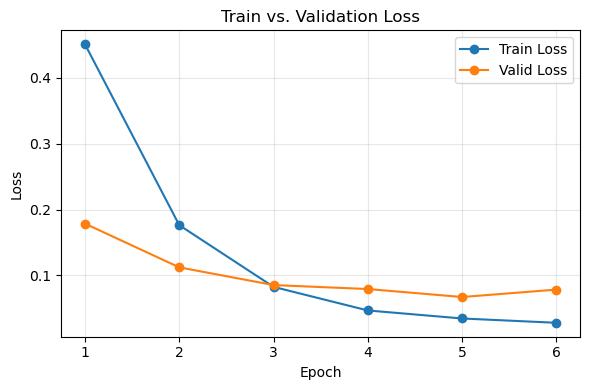

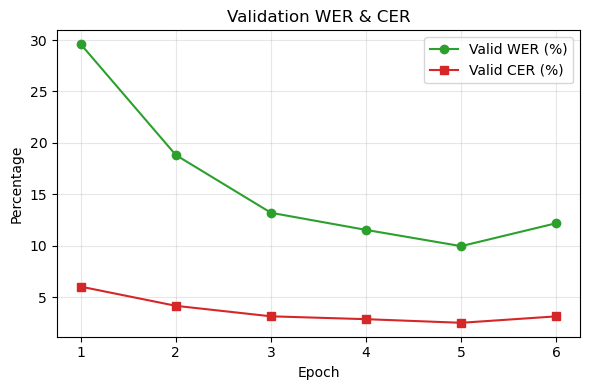

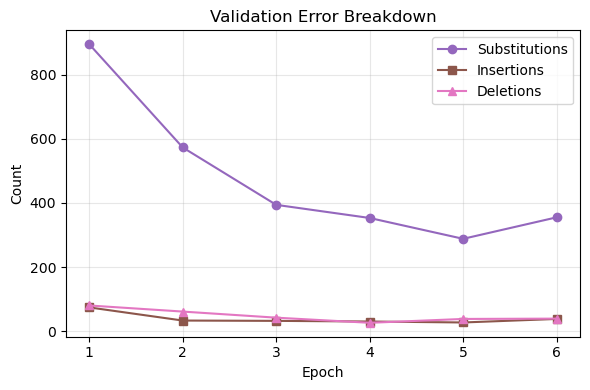

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("epoch_metrics.csv")
epochs = df["epoch"]

# 1) Train vs. Validation Loss
plt.figure(figsize=(6, 4))
plt.plot(epochs, df["train_loss"], marker="o", color="C0", label="Train Loss")
plt.plot(epochs, df["valid_loss"], marker="o", color="C1", label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs. Validation Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("train_vs_valid_loss.png")
plt.show()

# 2) Validation WER & CER
plt.figure(figsize=(6, 4))
plt.plot(epochs, df["valid_WER_%"], marker="o", color="C2", label="Valid WER (%)")
plt.plot(epochs, df["valid_CER_%"], marker="s", color="C3", label="Valid CER (%)")
plt.xlabel("Epoch")
plt.ylabel("Percentage")
plt.title("Validation WER & CER")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("valid_wer_cer.png")
plt.show()

# 3) Error Breakdown (Substitutions / Insertions / Deletions)
plt.figure(figsize=(6, 4))
plt.plot(epochs, df["substitutions"], marker="o", color="C4", label="Substitutions")
plt.plot(epochs, df["insertions"],    marker="s", color="C5", label="Insertions")
plt.plot(epochs, df["deletions"],     marker="^", color="C6", label="Deletions")
plt.xlabel("Epoch")
plt.ylabel("Count")
plt.title("Validation Error Breakdown")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("error_breakdown.png")
plt.show()